In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
# https://www.mathworks.com/matlabcentral/answers/217746-implementing-a-sine-wave-with-linearly-changing-frequency
# For getting a periodic signal with constantly changing frequency

t_step = 0.001
f1 = 17
t1 = np.arange(0,2000)
f1 = np.linspace(f1-2,f1+2,3*len(t1))
p1 = np.cumsum(f1*t_step)
f2 = 30
t2 = np.arange(0,2000)
f2 = np.linspace(f2+5,f2-5,3*len(t2))
p2 = np.cumsum(f2*t_step)

net1, F1_true, _ = utils.make_network(f1, len(t1), \
                   np.hstack([i*np.ones(50) for i in [1,2]]), \
                   np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(-30,30,10)]]),\
                   time_mod = np.arange(500,2500)/2000)
net2, F2_true, _ = utils.make_network(f2, len(t2), \
                   np.hstack([i*np.ones(50) for i in [2,1]]), \
                   np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,-10,10)]]))
x = np.zeros((100,2000))
x[:,t1] += net1
x[:,t2] += net2
x = utils.add_noise(x, std=0.1)
t = np.arange(x.shape[1]) * t_step

Text(0, 0.5, 'Channel')

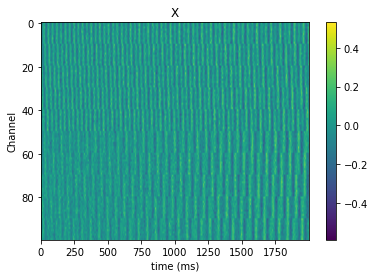

In [3]:
plt.imshow(x, aspect='auto')
plt.colorbar()
plt.title('X')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

In [4]:
model = nsdmd.NSDMD(opt_rank=4, sim_thresh_phi_amp=0.95, sim_thresh_freq=1, verbose=True, opt_win=200, opt_stride=50)
model.fit_opt(x, t)

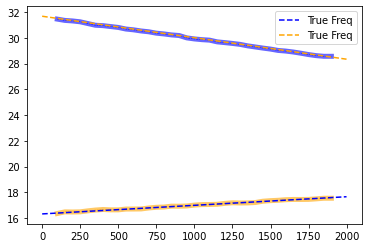

In [5]:
group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, \
                                      model.sim_thresh_freq, model.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange', 'red', 'green']
for i in range(0,len(group_idx),2):
    plt.plot(x_extent, model.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            plt.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            plt.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])
plt.plot(f1[len(t1):2*len(t1)], color=colors[0], linestyle='dashed', label='True Freq')
plt.plot(f2[len(t2):2*len(t2)], color=colors[1], linestyle='dashed', label='True Freq')
plt.legend()

In [6]:
group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, model.sim_thresh_freq, model.sim_thresh_phi_amp)

In [ ]:
def get_soln(freqs, phis, t, offsets):
    soln = np.empty((freqs.shape[0], phis.shape[1], len(t)))
    for i in range(len(freqs)):
        temp = np.exp(2*np.pi*1j*((t-offsets[i]) * freqs[i]))
        temp2 = phis[i,:][:,None]*temp
        soln[i] = temp2.real
    
    return(soln)

In [7]:
def get_freq_across_time(freqs, windows, t_len, N):
    freqs_all = np.empty((len(freqs), t_len))
    for i in range(len(freqs)):
        freqs_wide = freqs[i][:,None]*np.ones((windows.shape[1]))[None,:]
        freqs_row = np.empty((t_len))
        for j in range(t_len):
            idx = tuple(np.argwhere(windows==j).T)
            temp = freqs_wide[idx]
            freqs_row[j] = np.mean(temp)
        freqs_m = utils.moving_average_dim(freqs_row, N, 0)
        freqs_all[i] = np.hstack((freqs_m[0]*np.ones(t_len-len(freqs_m)-int(N/2)),\
                                  freqs_m,\
                                  freqs_m[-1]*np.ones(int(N/2))))
    return(freqs_all)

In [8]:
from scipy.stats import circmean

In [9]:
def get_soln_var_freq(freqs, phis, windows, t_len, t_step):
    soln = np.empty((freqs.shape[0], phis.shape[2], len(t)))
    for i in range(len(freqs)):
        freqs_wide = freqs[i][:,None]*np.ones((windows.shape[1]))[None,:]
        freqs_row = np.empty((t_len))
        phis_wide = phis[i][:,None,:]*np.ones((windows.shape[1]))[None,:,None]
        phis_row = np.empty((t_len, phis.shape[2]), dtype=complex)
        for j in range(t_len):
            idx = tuple(np.argwhere(windows==j).T)
            temp = freqs_wide[idx]
            freqs_row[j] = np.mean(temp)
            
            temp = phis_wide[idx]
            a = np.mean(np.abs(temp), axis=0)
            # p = np.sum(np.angle(temp), axis=0)%(2*np.pi)
            # p = np.mean(np.angle(temp), axis=0)
            p = circmean(np.angle(temp), axis=0, high=np.pi, low=-np.pi)
            phis_row[j] = a*np.exp(1j*p)
        phase_in = np.cumsum(freqs_row * t_step)
        temp = np.exp(2*np.pi*1j*phase_in)
        soln[i] = (phis_row*temp[:,None]).real.T
    return(soln)

In [10]:
def get_phi_init(freqs, phi, offset, t_step):
    phase_in = np.cumsum(freqs*t_step, axis=1)
    t_diff = np.exp(-2*np.pi*1j*phase_in[:,offset])
    return(phi*t_diff.T[:,:,None])

In [11]:
freqs_time = get_freq_across_time(model.freqs_.T, model.windows_, len(t), 51)

In [12]:
phis_init = get_phi_init(freqs_time, model.phis_, model.windows_[:,0], t_step)

In [13]:
soln = get_soln_var_freq(model.freqs_[:,np.array([0,2])].T, \
                         np.transpose(phis_init[:,np.array([0,2]),:], [1,0,2]), \
                         model.windows_, len(t), t_step)

In [52]:
f_hat = nsdmd.grad_f(x, soln, 0., model.grad_beta, \
                     model.grad_N, model.grad_lr, model.grad_maxiter, \
                     False, None)
f_hat = nsdmd.grad_f_amp(f_hat, soln, x)

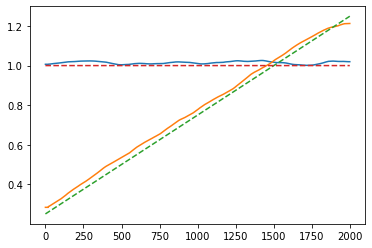

In [53]:
plt.plot(f_hat[0])
plt.plot(f_hat[1])
plt.plot(np.mean(F1_true, axis=0), linestyle='dashed')
plt.plot(np.mean(F2_true, axis=0), linestyle='dashed')
# plt.ylim(0,1.1)

In [169]:
model.fit_reduction(x, t)

0/2
1/2


Text(0, 0.5, 'Cosine Distance')

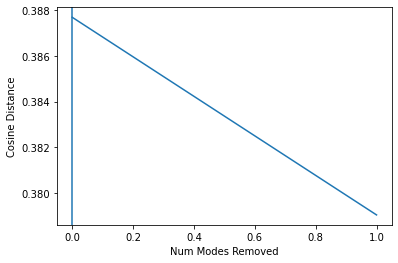

In [170]:
plt.plot(model.errors_)
plt.axvline(0)
plt.xlabel('Num Modes Removed')
plt.ylabel('Cosine Distance')

In [26]:
model.fit_f(x, t, t_step, 0)

/tmp/ipykernel_2629/422705195.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + alpha)


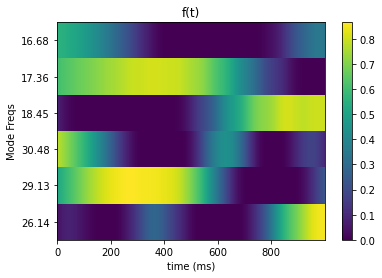

In [27]:
alpha = [str(np.round(f,2)) for f in model.freq_hat_]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(model.f_hat_[:,500:-500], aspect='auto')
fig.colorbar(cax)
ax.set_yticklabels([''] + alpha)
ax.xaxis.set_ticks_position('bottom')
plt.title('f(t)')
plt.xlabel('time (ms)')
plt.ylabel('Mode Freqs')
plt.show()

In [31]:
model.fit_f(x, t, t_step, 27)

/tmp/ipykernel_2629/422705195.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + alpha)


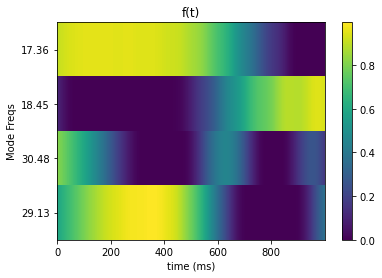

In [32]:
alpha = [str(np.round(f,2)) for f in model.freq_hat_]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(model.f_hat_[:,500:-500], aspect='auto')
fig.colorbar(cax)
ax.set_yticklabels([''] + alpha)
ax.xaxis.set_ticks_position('bottom')
plt.title('f(t)')
plt.xlabel('time (ms)')
plt.ylabel('Mode Freqs')
plt.show()

In [28]:
x_rec = model.transform(x, t)

Text(0, 0.5, 'Channel')

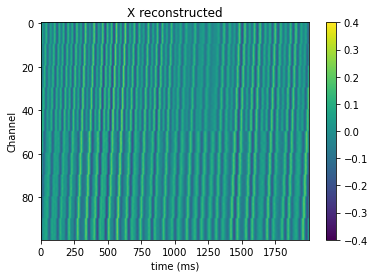

In [33]:
plt.imshow(x_rec, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X reconstructed')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0, 0.5, 'Channel')

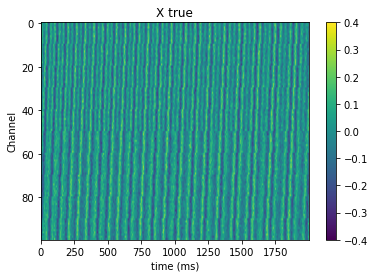

In [34]:
plt.imshow(x, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X true')
plt.xlabel('time (ms)')
plt.ylabel('Channel')